In [71]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using InvertedIndices
    using Random
    using Statistics
    using DiffEqCallbacks
    using Test
    using ChainRulesCore
    using LineSearches
    using CSV
    using DataFrames
end 

In [72]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [73]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


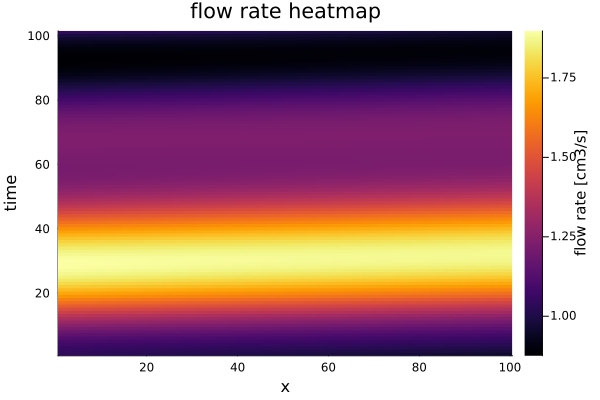

In [74]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];

heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


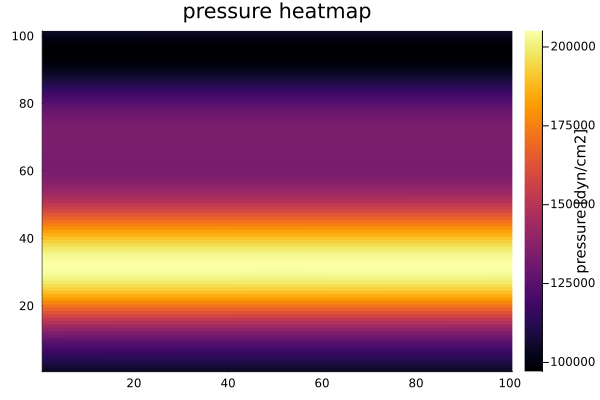

In [75]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [76]:
begin
    global dt = 0.001                     # time step, has to be smaller or equal to saveat
    global T = 1.0                   # total time
    global saveat = 0.01                #ground truth data time resolution
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem
    global L = 4.0                       # total length of 1d sim
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.01         # learning rate , currently using PolyOpt default (0.1)


end

0.01

In [77]:
#waveforms to use
waveforms = 30


# Set the seed for reproducibility
Random.seed!(1234)

# Shuffle the indices of the vector
shuffled_indices = randperm(size(data1d_fix)[3])

# Divide the shuffled indices into training and test sets
train_indices = shuffled_indices[1:waveforms];
test_indices = shuffled_indices[waveforms+1:end];

# # Shuffle the indices of the vector
# shuffled_indices = 1:47

# # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[18:end];
# test_indices = shuffled_indices[1:17];

# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [78]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];

In [79]:
#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];

#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];

In [80]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];

In [81]:
presID = 2
#ground truth data for pressure
ptrain = data1d_fix[:,1:end,train_indices,presID];
ptrain1 = data1d_fix[:,1:end,1,presID];

ptest = data1d_fix[:,1:end,test_indices,presID];

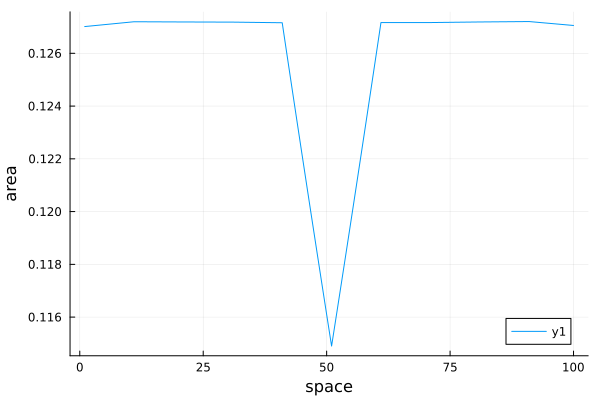

In [82]:
plot(Atrain1[1,:])
xlabel!("space")
ylabel!("area")

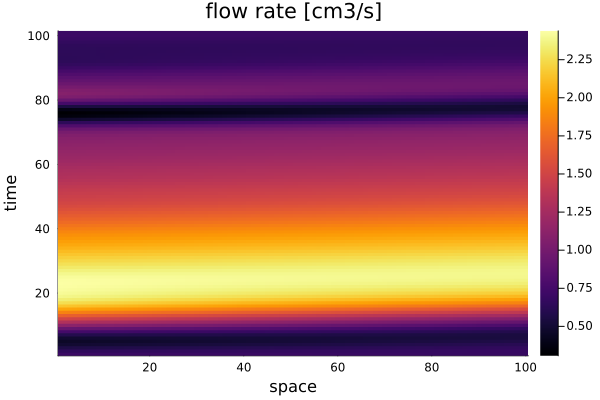

In [83]:
heatmap(ytrain2[:,:,1])
xlabel!("space")
ylabel!("time")
title!("flow rate [cm3/s]")

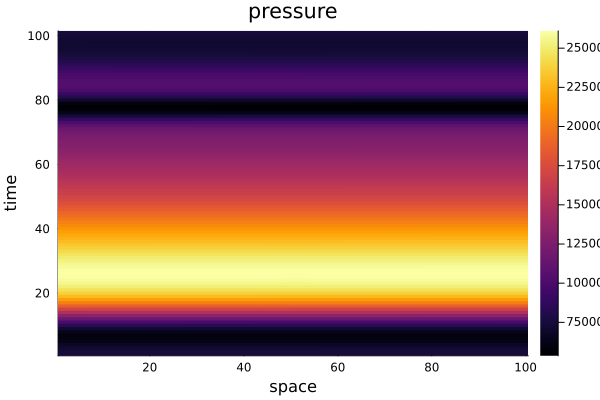

In [84]:
heatmap(ptrain[:,:,1])
xlabel!("space")
ylabel!("time")
title!("pressure")

In [85]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [86]:
N = size(u01,1)
dx = L/N                      # spatial step
x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
# finite-difference schemes

#first order derivatives
∂x1_center = f1_secondOrder_central(N,dx);
∂x1_forward = f1_secondOrder_forward(N,dx);
∂x1_backward = f1_secondOrder_backward(N,dx);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(N,dx);
∂x2_forward = f2_secondOrder_forward(N,dx);
∂x2_backward = f2_secondOrder_backward(N,dx);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [87]:

# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(100 => 10, tanh),               # 1_010 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 100),                     # 1_100 parameters
)                   # Total: 8 arrays, 2_330 parameters, 9.602 KiB.

In [88]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


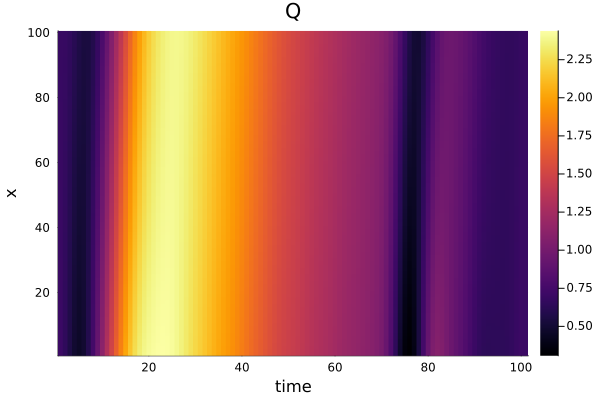

In [89]:
ytrain = permutedims(ytrain2[:,:,:],(2,3,1))

heatmap(ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("Q")

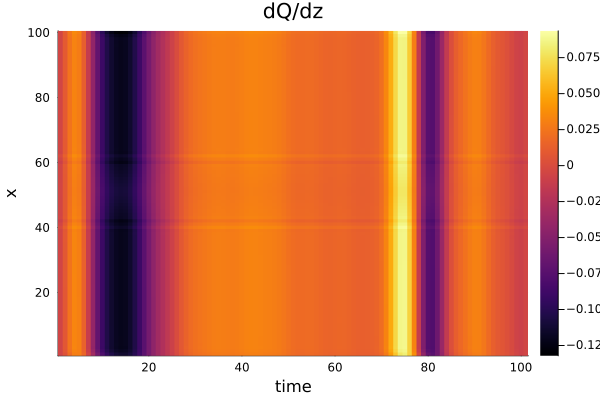

In [90]:
#plot derivatives for sanity check
heatmap(∂x1*ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dQ/dz")

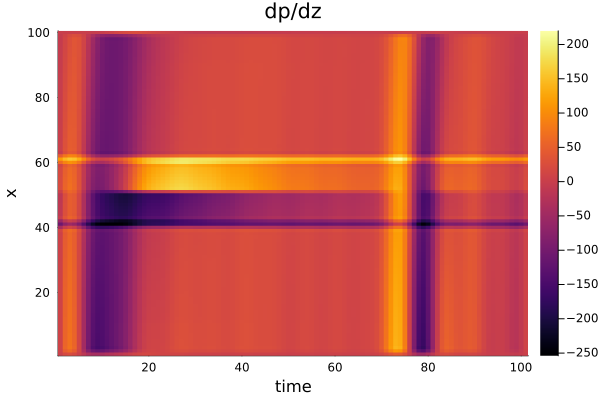

In [91]:
prestrain = permutedims(ptrain[:,:,:],(2,3,1))
heatmap(∂x1*prestrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dp/dz")

In [92]:
δ = 1/3;  #profile parameters
ν = 0.04; # viscosity in CGS
ρ = 1.06; #density in CGS
Nprof = -8*π*ν;  #profile parameters

In [93]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / saveat)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * saveat) / saveat

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    
    if t == T
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# define interpolate function
interp_func(t) = interpolate_variables(t, atrain)

interp_func (generic function with 1 method)

In [94]:
function learn_1DBlood(u, p, t, interp_func, p_interp_func)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    # u - variable we are solving for
    # p - parameters
    # t - time
    #interp_func - interpolates area to the current t
    #p_interp_func - interpolates pressure to current t
    
    # omit the pressure term for now:  - interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t)) 
    #- (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) + Nprof .* u ./ interp_func(t) + ν .* (∂x2*u)
    
    
    # write out each term for debugging
#     if isapprox(t%0.1,0.0, atol = 1e-3)
#         println("time t: ", t)
#         println("advection term d/dz(Q^2/S): ", sum((1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t)))))
#         println("viscous resistance N*Q/S: ", sum(Nprof .* u ./ interp_func(t)))
#         println("Diffusion: nu*d^2Q/dz^2: ", sum(ν .* (∂x2*u)))
#         println("Mean area S: ", mean(interp_func(t)))
#         println("Mean Previous flow rate Q:", mean(u), ", std Q:", std(u))
#         println("Mean Q^2/S:", mean((u .* u) ./ interp_func(t)))
#         println("dp/dz term: ", sum(- interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t))))
#         println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
#         flush(stdout)
#     end
    
#     plotQ = plot(u)
#     display(plot(plotQ))
#     sleep(1)
    
    #construct ODE
    return Φ(u) - (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t)))
end

learn_1DBlood (generic function with 1 method)

In [95]:
# if RK4 - then uses the self-implemented RK4
# if Tsit5 - uses callback
# at the moment both crash :(
ode_solver = "RK4"
output_dir = "/home/tschala/research/LANL/some_physics_testNODE"
working_dir = output_dir

"/home/tschala/research/LANL/some_physics_testNODE"

In [96]:
# Runge-Kutta solver
function rk4_solve_1step(prob, θ, dt,tf,u0)
    # set initial condition
    u = u0
    
    # set problem right-hands side function
    f = prob.f
    
    # set initial time, one step before the final time
    ti = tf-dt
    
#     println("ti: ",ti)
    
    #calculate Runge-Kutta step
    k1 = f(u, θ, ti)
    k2 = f(u .+ dt/2 .* k1, θ, ti + dt/2)
    k3 = f(u .+ dt/2 .* k2, θ, ti + dt/2)
    k4 = f(u .+ dt .* k3, θ, ti + dt)

    u_new = u .+ dt/6 .* (k1 .+ 2*k2 .+ 2*k3 .+ k4)

    return u_new
end


rk4_solve_1step (generic function with 1 method)

In [97]:
function loss(θ, ytrain21, prob,bc_left)
    # solve system and calculate loss
    
    # θ - NN parameters
    # ytrain21 - ground truth data - shape: [space, batch, time]
    # prob - ODE problem formulation
    # bc_left - time-dependent BC 
    
    # list for saving results
    pred = []
    
    # initialize loss
    loss = 0.0
    
    # get the time span from the problem setup
    t0, tf = prob.tspan
    
    # get initial conditions
    u0 = prob.u0

    # save IC to list
    # MUST ignore gradients, otherwise mutation will occur
    # push creates mutation if derivatives are not ignored
    @ignore_derivatives push!(pred, u0)
    
    # calculate number of timesteps required
    num_steps = Int(round((tf - t0) / dt))
    
    # timestep loop
    for i in 1:num_steps
        
        # integrate one timestep at a time to avoid mutating arrays
        
        # set final time to 1 timestep ahead
        tf = dt*i
        
        # solve 1 time-step
        u_new = rk4_solve_1step(prob, θ, dt,tf,u0)
        

        
        # calculate the loss when time is the same as the ground truth
        # saveat is the time resolution of the ground truth data
        t_ratio = saveat/dt
        if isapprox(i % t_ratio, 0.0, atol=1e-6)
            # calculate index corresponding to time in the ground truth data
            index = Int(round(i /t_ratio))
            # cumulate the loss
            l = sum(abs2, u_new - ytrain21[:, :, index])
            loss += l
        end
        
        # apply inlet boundary condition
        bc_zeros = zeros(1,size(u0)[2])
        # create matrix which is 1 everywhere but 0 at the BC
        multiply = Float32.(vcat(bc_zeros,ones(size(u0)[1]-1,size(u0)[2])))
        
        # interpolate BC to current time step
        t_index = Int(floor(tf / saveat)) + 1

        # calculate local time fraction between the grid points
        t_frac = (tf - (t_index - 1) * saveat) / saveat

        # Perform linear interpolation between data points in vector
        # if we are at the last timesteps just copy the value cause t_index+1 will not exist
        if tf == T
            bc_interp = bc_left[t_index,:]
        else
            bc_interp = (1 - t_frac) * bc_left[t_index,:] + t_frac * bc_left[t_index + 1, :]
        end
        
        # create matrix that is zero everywhere except the BC, where it is the BC
        add = Float32.(vcat(reshape(bc_interp,1,size(bc_left)[2]),zeros(size(u0)[1]-1,size(u0)[2])))
        
        # set the new initial condition
        # use copy to avoid mutating arrays
        # apply BC by multiplying and adding, this is just a way to overcome mutation
        u0 = copy(u_new).*multiply.+add
        
        # save result to list, ignore gradients to avoid mutation
        if isapprox(i % t_ratio, 0.0, atol=1e-6)
            @ignore_derivatives push!(pred, u_new)
        end
        
    end
    
    #return the total loss at the end
    return loss, pred
end


# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob,bc_left),adtype) ;

In [98]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [99]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:RK4


In [100]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


Batch size:10
Start training epoch 1
waveform batch: 1/3
Using ADAM optimizer
Sum of params:2.5065749
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 8494.890814707647
Iteration: 2 || Loss: 8334.639364817356
Iteration: 3 || Loss: 8213.573930923181
Iteration: 4 || Loss: 8099.910085465911
Iteration: 5 || Loss: 7989.341671288533
Iteration: 6 || Loss: 7989.341671288533
saving ADAM checkpoint...
Sum of params:23.831387
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 7989.341671288533
Iteration: 2 || Loss: 7516.782712084535
Iteration: 3 || Loss: 7391.778748428178
Iteration: 4 || Loss: 7364.637512829269
Iteration: 5 || Loss: 7321.380016127992
Iteration: 6 || Loss: 6395.990321656624
Iteration: 7 || Loss: 5390.695354605474
Iteration: 8 || Loss: 4628.715658850243
Iteration: 9 || Loss: 4594.02554969437
Iteration: 10 || Loss: 4163.729278870045
Iteration: 11 || Loss: 3421.027752753447
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.

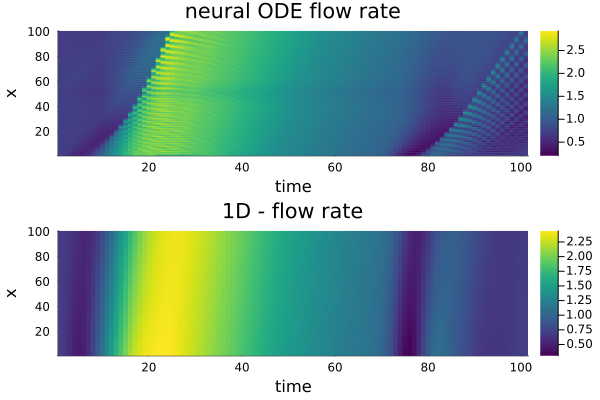

waveform batch: 2/3
Using ADAM optimizer
Sum of params:131.50589
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 1531.8841558938
Iteration: 2 || Loss: NaN
Iteration: 3 || Loss: NaN
Iteration: 4 || Loss: NaN
Iteration: 5 || Loss: NaN
Iteration: 6 || Loss: 1531.8841558938
saving ADAM checkpoint...
Sum of params:131.50589
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 1531.8841558938
Iteration: 2 || Loss: 1408.1289838836508
Iteration: 3 || Loss: 1388.8735023299942
Iteration: 4 || Loss: 1362.7996715535585
Iteration: 5 || Loss: 1215.519887112309
Iteration: 6 || Loss: 1199.7494652302944
Iteration: 7 || Loss: 1116.614410822359
Iteration: 8 || Loss: 1094.247002264157
Iteration: 9 || Loss: 957.7354548003784
Iteration: 10 || Loss: 876.4668076274008
Iteration: 11 || Loss: 813.5787176420686
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:121.01382
Epoch 1 loss:813.5787176420686


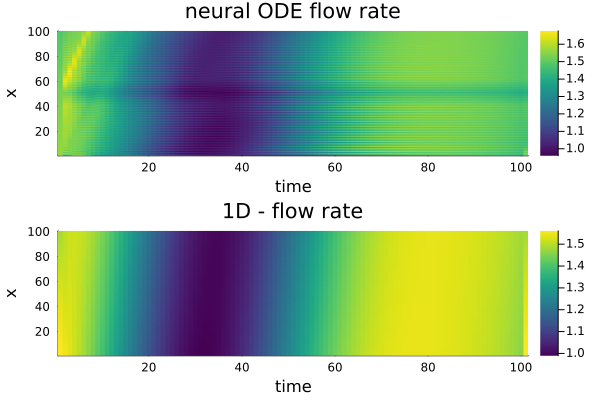

waveform batch: 3/3
Using ADAM optimizer
Sum of params:121.01382
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 548.896053864606
Iteration: 2 || Loss: 608.825104486877
Iteration: 3 || Loss: 469.8002582899246
Iteration: 4 || Loss: 447.5697822801858
Iteration: 5 || Loss: 451.5089787004894
Iteration: 6 || Loss: 447.5697822801858
saving ADAM checkpoint...
Sum of params:134.20348
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 447.5697822801858
Iteration: 2 || Loss: 422.552810604421
Iteration: 3 || Loss: 416.87402856893254
Iteration: 4 || Loss: 297.354224150576
Iteration: 5 || Loss: 266.62984775625347
Iteration: 6 || Loss: 258.8538849892537
Iteration: 7 || Loss: 251.98882295096166
Iteration: 8 || Loss: 228.20815756299615
Iteration: 9 || Loss: 223.9911574815181
Iteration: 10 || Loss: 217.36539729010977
Iteration: 11 || Loss: 195.854718462796
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:140.046
Epoch 1 l

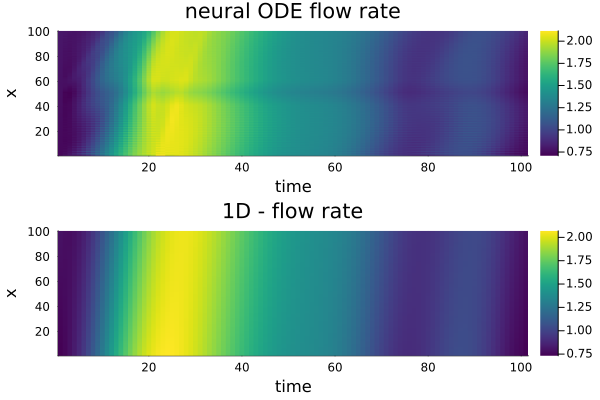

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/2
Test loss:242.48703383763535


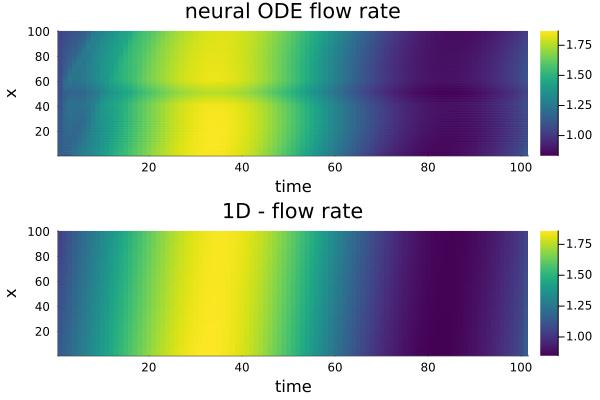

waveform batch: 2/2
Test loss:391.02392887385855


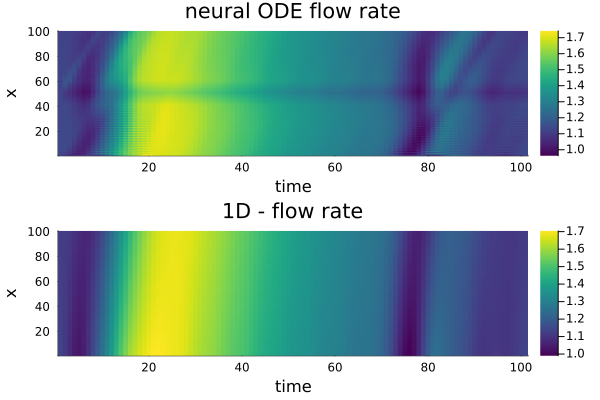

Epoch 1 mean train loss:147.6820396286104
Epoch 1 mean test loss:37.265350747734935
Start training epoch 2
waveform batch: 1/3
Using ADAM optimizer
Sum of params:140.046
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 1081.0206751501557
Iteration: 2 || Loss: 1128.9161978571742
Iteration: 3 || Loss: 975.4989657420679
Iteration: 4 || Loss: 980.3102175559077
Iteration: 5 || Loss: 967.4180055657141
Iteration: 6 || Loss: 967.4180055657141
saving ADAM checkpoint...
Sum of params:139.9195
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 967.4180055657141
Iteration: 2 || Loss: 893.3686318671658
Iteration: 3 || Loss: 891.242388122393
Iteration: 4 || Loss: 675.1876623071245
Iteration: 5 || Loss: 571.011239532077
Iteration: 6 || Loss: 564.9330454106009
Iteration: 7 || Loss: 562.6888343510415
Iteration: 8 || Loss: 536.5507456619379
Iteration: 9 || Loss: 509.49021257679357
Iteration: 10 || Loss: 441.10566377857214
Iteration: 11 || Loss: 400.68372908

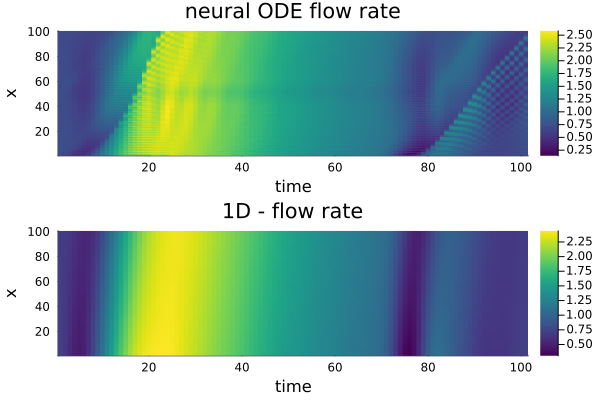

waveform batch: 2/3
Using ADAM optimizer
Sum of params:217.64436
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 176.65153712195018
Iteration: 2 || Loss: 459.8870705289644
Iteration: 3 || Loss: 172.8008033187796
Iteration: 4 || Loss: 166.44161114016777
Iteration: 5 || Loss: 276.79283848856954
Iteration: 6 || Loss: 166.44161114016777
saving ADAM checkpoint...
Sum of params:213.32616
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 166.44161114016777
Iteration: 2 || Loss: 118.44179461504628
Iteration: 3 || Loss: 117.7039230687331
Iteration: 4 || Loss: 109.96953709451675
Iteration: 5 || Loss: 109.42252676949016
Iteration: 6 || Loss: 109.26754000591157
Iteration: 7 || Loss: 101.54275712404069
Iteration: 8 || Loss: 98.41252650559613
Iteration: 9 || Loss: 98.3273181444987
Iteration: 10 || Loss: 96.81955878799424
Iteration: 11 || Loss: 90.52371842497757
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:214.8675

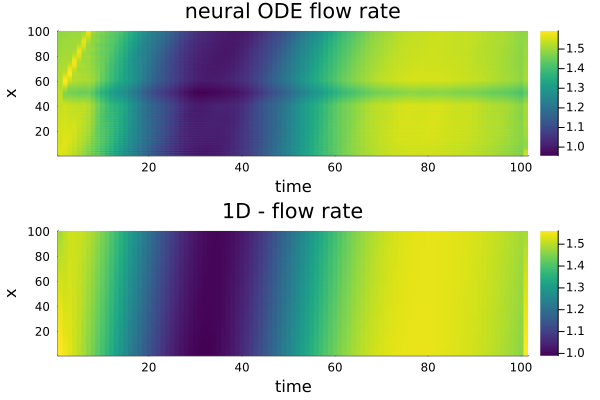

waveform batch: 3/3
Using ADAM optimizer
Sum of params:214.86757
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 76.54169729737963
Iteration: 2 || Loss: 421.23008410566763
Iteration: 3 || Loss: 77.2766733260623
Iteration: 4 || Loss: 252.28479999817566
Iteration: 5 || Loss: 275.95400696537047
Iteration: 6 || Loss: 76.54169729737963
saving ADAM checkpoint...
Sum of params:214.86757
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 76.54169729737963
Iteration: 2 || Loss: 75.737314757041
Iteration: 3 || Loss: 72.60717076700442
Iteration: 4 || Loss: 71.42067417504303
Iteration: 5 || Loss: 68.66539625815957
Iteration: 6 || Loss: 66.7240011385365
Iteration: 7 || Loss: 64.95524348885843
Iteration: 8 || Loss: 64.3677587627355
Iteration: 9 || Loss: 62.999728298784916
Iteration: 10 || Loss: 62.70064374622567
Iteration: 11 || Loss: 61.93445832180065
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:215.09512
Epoch 2 

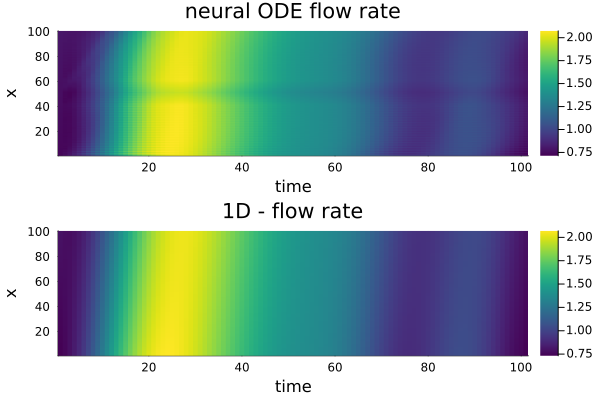

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/2
Test loss:67.21051478896473


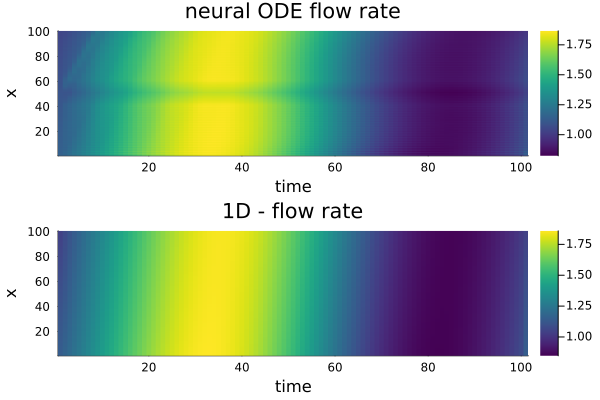

waveform batch: 2/2
Test loss:105.73748124659244


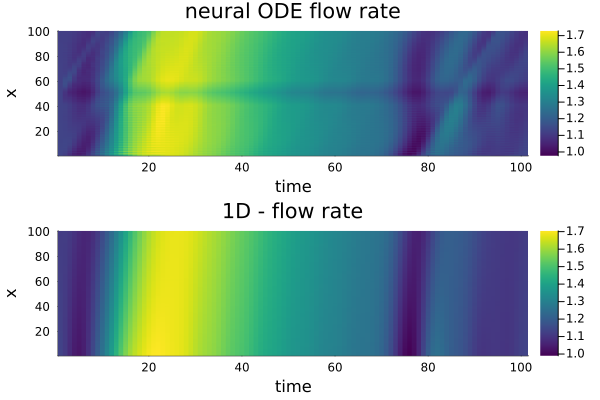

Epoch 2 mean train loss:18.43806352770728
Epoch 2 mean test loss:10.173411531503362


In [101]:
n_epochs = 2

#set batch size
batch_size = 10
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(size(ytrain2,3)/batch_size)
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));

list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
# epochs loop
learning_rate = 0.01
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test = 0.0
    # Change learning rate for ADAM optimizer, BFGS doesn't use it
    if j % 3 == 0 && learning_rate > 1e-6
        global learning_rate = learning_rate*0.1
        println("Changing learning rate to:",learning_rate)
    end
        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)



            flush(stdout)
            #reorder ytrain, atrain and dAdz to [space, batch_size, time]
            # batch size should be second column
            ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
        
            #define boundary condition for the current batch
            bctrain = bc_flow[:,batch_size*(i-1)+1:batch_size*i]
        
            #reorder pressure values as well
            prestrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))


            #define function for interpolating area to the actual time location for the ODE
            interp_func(t) = interpolate_variables(t, atrain)
            p_interp_func(t) = interpolate_variables(t, prestrain)
            
        
            #define optimization problem
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytrain[:,:,1], tspan, p);
            
            optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob, bctrain),adtype) ;

            println("Using $optimizer_choice1 optimizer")
            println("Sum of params:", sum(uinit))


            global uninit
            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
            println("Sum of params:", sum(uinit))

            if !isnothing(optimizer_choice2)
                println("Switching to $optimizer_choice2 optimizer")

                uinit = train_loop(uinit,adtype,optf,train_maxiters*2,learning_rate,optimizer_choice2)

                println("Sum of params:", sum(uinit))

            end
        
            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,p_interp_func), ytrain[:,:,1], tspan, p);
            l, pred = loss(uinit,ytrain[:,:,:],prob,bctrain)
            loss_tot = loss_tot + l

            push!(list_loss_train, l)
            println("Epoch ", j, " loss:", l)
        
        
            # Initialize the resulting matrix
            pred_matrix = zero(ytrain)

            # Restructure the matrices into the result matrix
            for i in 1:length(pred)
                pred_matrix[:, :, i] = pred[i]
            end

        
         
            # plot solution for comparison
            plot1 = heatmap(pred_matrix[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytrain[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end
    
    
        #testing loop
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        println("Testing:")

        for i in 1:test_batch_iterations

            println("waveform batch: ",i, "/",test_batch_iterations)

            #reorder ytrain to (spatial location, batch_size, time)
            if i!=test_batch_iterations
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:batch_size*i]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            else
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:end]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:end],(2,3,1))
            end
            

            #define function for interpolating area and dA/dz to the actual spatial location for the ODE
            interp_func(t) = interpolate_variables(t, atest)
            p_interp_func(t) = interpolate_variables(t, prestest)

            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytest[:,:,1], tspan, p);
            l, pred = loss(uinit,ytest[:,:,:],prob,bctest)
            loss_tot_test = loss_tot_test + l

            push!(list_loss_test, l)
            println("Test loss:",l )
        
            # Initialize the resulting matrix
            pred_matrix = zero(ytest)

            # Restructure the matrices into the result matrix
            for i in 1:length(pred)
                pred_matrix[:, :, i] = pred[i]
            end
        

            #plot solution for comparison
            plot1 = heatmap(pred_matrix[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytest[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end


push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
println("Epoch ", j, " mean test loss:", loss_tot_test/(size(ytest2,3)))
end


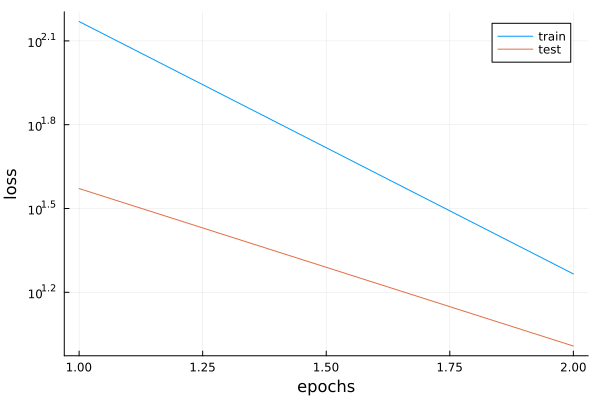

In [102]:
# plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test], yaxis=:log, label = ["train" "test"])
ylabel!("loss")
xlabel!("epochs")
png("dQdt_1DBlood_loss.png")
display(p3)

In [109]:
# write loss to CSV file
df = DataFrame([list_loss_epoch,list_loss_epoch_test], ["train", "test"])
CSV.write("output.csv", df, writeheader=true)

"output.csv"

### Load the final learnt parameters and do inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 5
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 2
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

In [ ]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

In [ ]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))